In [2]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model = "llama3.2",
    reasoning=False,
    temperature = 0.1,
)

In [3]:
from typing_extensions import Literal
from pydantic import BaseModel, Field


class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )


In [4]:
llm_router = llm.with_structured_output(Router)
llm_router

RunnableBinding(bound=ChatOllama(model='llama3.2', reasoning=False, temperature=0.1), kwargs={'format': {'description': 'Analyze the unread email and route it according to its content.', 'properties': {'reasoning': {'description': 'Step-by-step reasoning behind the classification.', 'title': 'Reasoning', 'type': 'string'}, 'classification': {'description': "The classification of an email: 'ignore' for irrelevant emails, 'notify' for important information that doesn't need a response, 'respond' for emails that need a reply", 'enum': ['ignore', 'respond', 'notify'], 'title': 'Classification', 'type': 'string'}}, 'required': ['reasoning', 'classification'], 'title': 'Router', 'type': 'object'}, 'ls_structured_output_format': {'kwargs': {'method': 'json_schema'}, 'schema': <class '__main__.Router'>}}, config={}, config_factories=[])
| PydanticOutputParser(pydantic_object=<class '__main__.Router'>)

In [5]:
profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

In [6]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage John's tasks efficiently."
}

In [7]:
from prompts import triage_system_prompt, triage_user_prompt

In [8]:
system_prompt = triage_system_prompt.format(
    full_name=profile["full_name"],
    name=profile["name"],
    examples=None,
    user_profile_background=profile["user_profile_background"],
    triage_no=prompt_instructions["triage_rules"]["ignore"],
    triage_notify=prompt_instructions["triage_rules"]["notify"],
    triage_email=prompt_instructions["triage_rules"]["respond"],
)

In [9]:
# Example incoming email
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [10]:
user_prompt = triage_user_prompt.format(
    author=email["from"],
    to=email["to"],
    subject=email["subject"],
    email_thread=email["body"],
)

In [11]:
result = llm_router.invoke(
    [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
)

In [12]:
result

Router(reasoning="This email is a direct question from Alice Smith regarding API documentation and requires clarification. It falls under the category of 'RESPOND' as it needs a direct response from John.", classification='respond')

## Main agent, define tools

In [13]:
from langchain_core.tools import tool

In [14]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

In [15]:
@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"



In [16]:
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

## Main agent, define prompt

In [35]:
from prompts import agent_system_prompt
from langgraph.prebuilt import create_react_agent
import json
def create_prompt(state):
    print("--- [create_prompt] 接收到的 State 內容 ---")
    # 使用 json.dumps 讓巢狀的字典更容易閱讀
    print(state)
    print("--- State 內容結束 ---")
    return [
        {
            "role": "system", 
            "content": agent_system_prompt.format(
                instructions=prompt_instructions["agent_instructions"],
                **profile
                )
        }
    ] + state['messages']

tools=[write_email, schedule_meeting, check_calendar_availability]
agent = create_react_agent(
    model="ollama:llama3.2",
    tools=tools,
    prompt=create_prompt,
)
response = agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "what is my availability for tuesday?"
    }]}
)

--- [create_prompt] 接收到的 State 內容 ---
{'messages': [HumanMessage(content='what is my availability for tuesday?', additional_kwargs={}, response_metadata={}, id='fec6dee2-bf0c-460c-93ba-1098353e79b5')], 'is_last_step': False, 'remaining_steps': 24}
--- State 內容結束 ---
--- [create_prompt] 接收到的 State 內容 ---
{'messages': [HumanMessage(content='what is my availability for tuesday?', additional_kwargs={}, response_metadata={}, id='fec6dee2-bf0c-460c-93ba-1098353e79b5'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-08-16T10:54:51.342517067Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2240856321, 'load_duration': 1817276042, 'prompt_eval_count': 445, 'prompt_eval_duration': 218490963, 'eval_count': 19, 'eval_duration': 203759042, 'model_name': 'llama3.2'}, id='run--c50bb607-8fc6-432d-ba83-b276de8218d5-0', tool_calls=[{'name': 'check_calendar_availability', 'args': {'day': 'Tuesday'}, 'id': '2850731a-3621-47ab-9f6a-359b457aa

In [24]:
response

{'input': 'what is my availability for tuesday?',
 'output': 'Your availability for Tuesday is as follows: 9:00 AM, 2:00 PM, and 4:00 PM.'}

## Create the Overall Agent

In [25]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [26]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [27]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

In [29]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile()

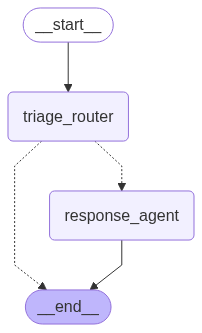

In [30]:
# Show the agent
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [31]:
email_input = {
    "author": "Marketing Team <marketing@amazingdeals.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "🔥 EXCLUSIVE OFFER: Limited Time Discount on Developer Tools! 🔥",
    "email_thread": """Dear Valued Developer,

Don't miss out on this INCREDIBLE opportunity! 

🚀 For a LIMITED TIME ONLY, get 80% OFF on our Premium Developer Suite! 

✨ FEATURES:
- Revolutionary AI-powered code completion
- Cloud-based development environment
- 24/7 customer support
- And much more!

💰 Regular Price: $999/month
🎉 YOUR SPECIAL PRICE: Just $199/month!

🕒 Hurry! This offer expires in:
24 HOURS ONLY!

Click here to claim your discount: https://amazingdeals.com/special-offer

Best regards,
Marketing Team
---
To unsubscribe, click here
""",
}

In [32]:
response = email_agent.invoke({"email_input": email_input})

🚫 Classification: IGNORE - This email can be safely ignored


In [33]:
response

{'email_input': {'author': 'Marketing Team <marketing@amazingdeals.com>',
  'to': 'John Doe <john.doe@company.com>',
  'subject': '🔥 EXCLUSIVE OFFER: Limited Time Discount on Developer Tools! 🔥',
  'email_thread': "Dear Valued Developer,\n\nDon't miss out on this INCREDIBLE opportunity! \n\n🚀 For a LIMITED TIME ONLY, get 80% OFF on our Premium Developer Suite! \n\n✨ FEATURES:\n- Revolutionary AI-powered code completion\n- Cloud-based development environment\n- 24/7 customer support\n- And much more!\n\n💰 Regular Price: $999/month\n🎉 YOUR SPECIAL PRICE: Just $199/month!\n\n🕒 Hurry! This offer expires in:\n24 HOURS ONLY!\n\nClick here to claim your discount: https://amazingdeals.com/special-offer\n\nBest regards,\nMarketing Team\n---\nTo unsubscribe, click here\n"},
 'messages': []}